# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import all the Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

### Import data into tensorflow dataset object

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Plantvillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20242 files belonging to 15 classes.


**Watch below video on tensorflow input pipeline first if you don't know about tensorflow datasets**

In [5]:
class_names = dataset.class_names
class_names


['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
no_class = len(class_names)
no_class

15

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 7  2  2 12  5 10 10  7  9  1  7 14  9 12  3  7  8 12  5  3 10  5 11  9
  5  9  5 12  3  9  9 12]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

**subplot() function**

The subplot() function takes three arguments that describes the layout of the figure.

The layout is organized in rows and columns, which are represented by the first and second argument.

The third argument represents the index of the current plot. 

### Visualize some of the images from our dataset

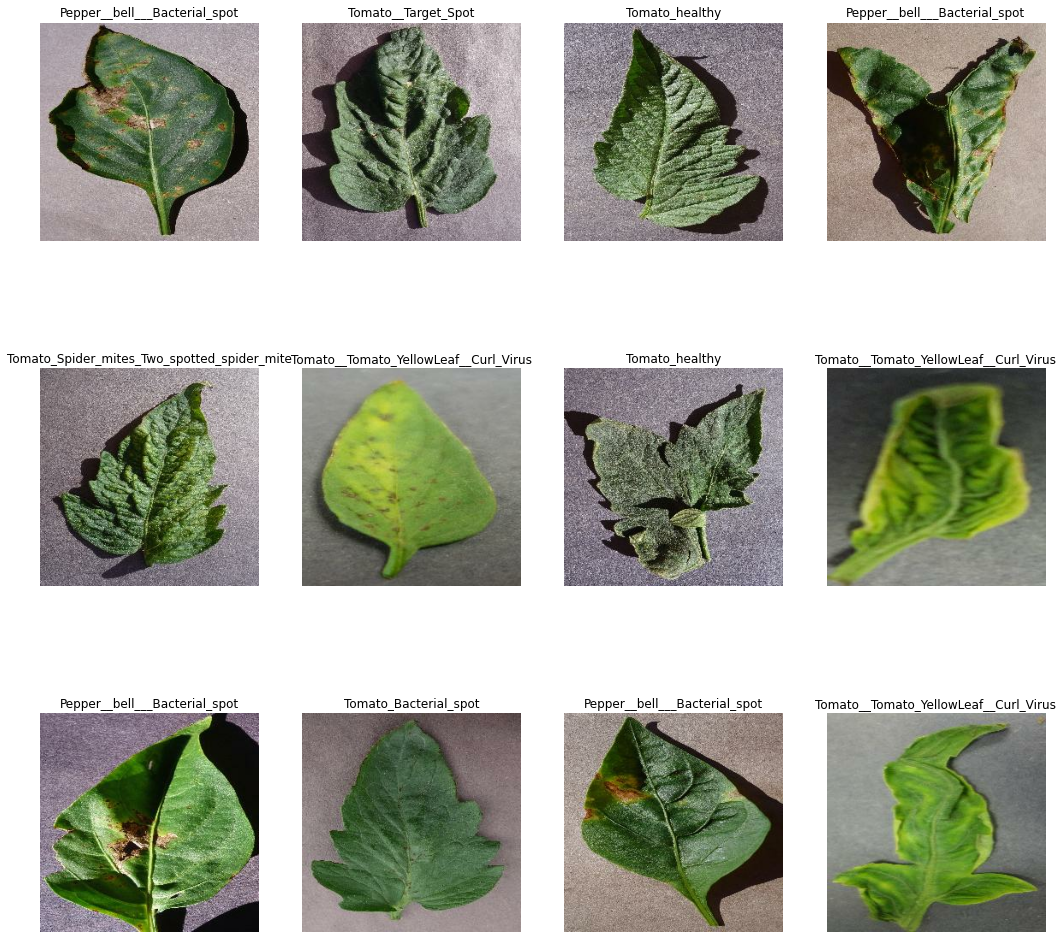

In [8]:
plt.figure(figsize=(18, 18))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)   #(row,coiumn,index)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [9]:
len(dataset)

633

In [10]:
train_size = 0.8
len(dataset)*train_size

506.40000000000003

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

579

In [13]:
val_size=0.1
len(dataset)*val_size

63.300000000000004

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

573

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1, 'sum of all split should be 1'
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

506

In [19]:
len(val_ds)

63

In [20]:
len(test_ds)

64

### Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



**Watch below video if you are not familiar with data augmentation**

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN**

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=27,
)

Epoch 1/27
506/506 [==============================] - 3117s 259ms/step - loss: 1.9428 - accuracy: 0.3628 - val_loss: 1.7919 - val_accuracy: 0.4494
Epoch 2/27
506/506 [==============================] - 146s 256ms/step - loss: 1.1771 - accuracy: 0.6089 - val_loss: 0.9067 - val_accuracy: 0.6903
Epoch 3/27
506/506 [==============================] - 145s 256ms/step - loss: 0.7697 - accuracy: 0.7396 - val_loss: 0.5972 - val_accuracy: 0.7827
Epoch 4/27
506/506 [==============================] - 145s 256ms/step - loss: 0.5735 - accuracy: 0.8061 - val_loss: 0.5651 - val_accuracy: 0.7932
Epoch 5/27
506/506 [==============================] - 145s 256ms/step - loss: 0.4757 - accuracy: 0.8347 - val_loss: 0.6666 - val_accuracy: 0.7718
Epoch 6/27
506/506 [==============================] - 145s 255ms/step - loss: 0.4274 - accuracy: 0.8505 - val_loss: 0.5287 - val_accuracy: 0.8219
Epoch 7/27
506/506 [==============================] - 145s 255ms/step - loss: 0.3858 - accuracy: 0.8638 - val_loss: 0.8016 

In [20]:
scores = model.evaluate(test_ds)

64/64 [==============================] - 17s 21ms/step - loss: 0.1512 - accuracy: 0.9517


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [21]:
scores

[0.15122778713703156, 0.95166015625]

In [22]:
import pickle
Pkl_Filename = "three_plant_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model,file)

In [ ]:
import pickle
model = pickle.load(open('three_plant_Model.pkl','rb'))

In [23]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/plant_disease_model") + [0]])+1
model.save(f"/content/drive/MyDrive/plant_disease_model/{model_version}")

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [24]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [25]:
history.params

{'verbose': 1, 'epochs': 27, 'steps': 506}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [27]:
type(history.history['loss'])

list

In [28]:
len(history.history['loss'])

27

In [29]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.9427540302276611,
 1.1770923137664795,
 0.7697246670722961,
 0.5735028386116028,
 0.4756886661052704]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

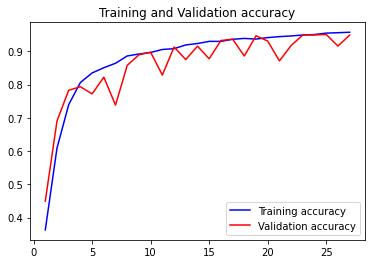

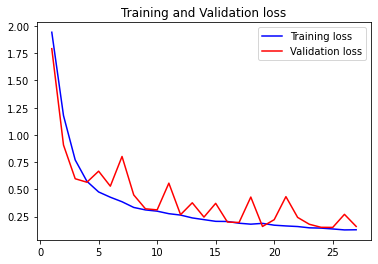

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Tomato_Late_blight
predicted label: Tomato_Late_blight


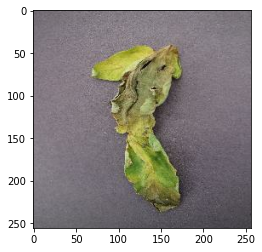

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

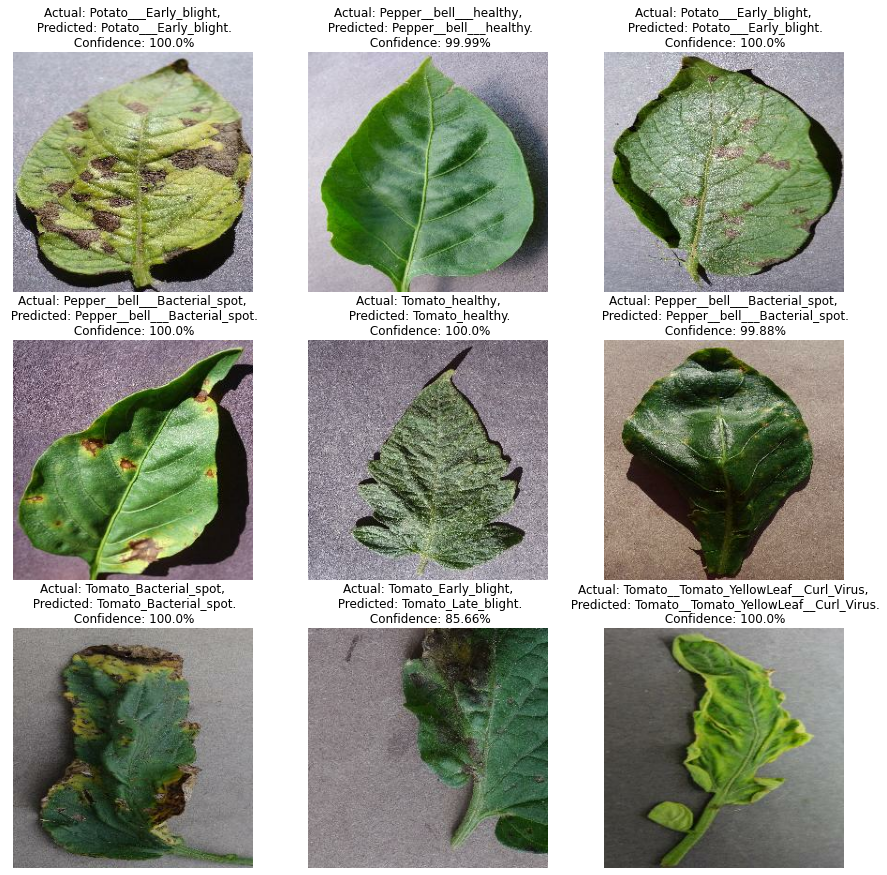

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [34]:
model.save("all_plant.h5")